Standard imports for parsing and displaying data

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import math

from sklearn.metrics import roc_curve

import os
%matplotlib inline
sns.set(style='ticks', palette='Set2')

Code to upload files

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving train.csv to train.csv
Saving test.csv to test.csv


This chunk of code helps visualize the data

['male', 'female']


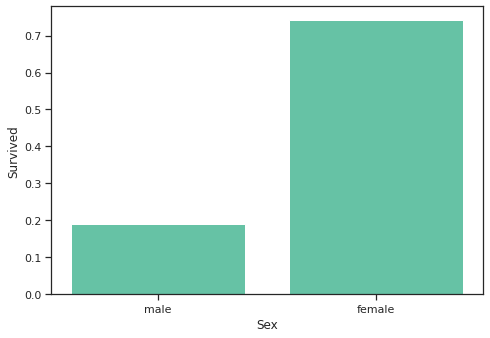

['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80']


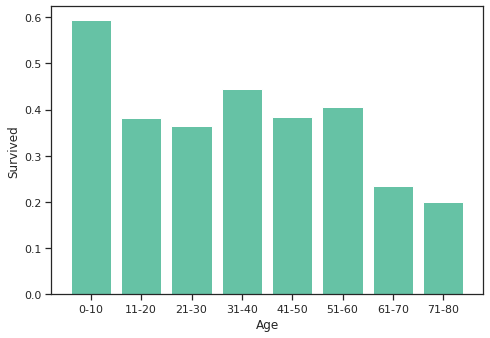

[1, 0, 3, 4, 2, 5, 8]


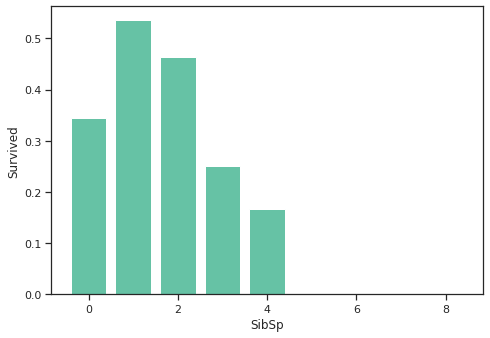

[0, 1, 2, 5, 3, 4, 6]


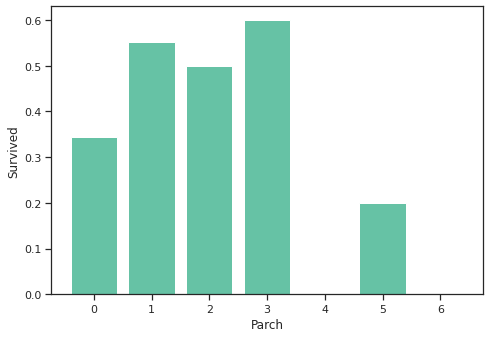

[3, 1, 2]


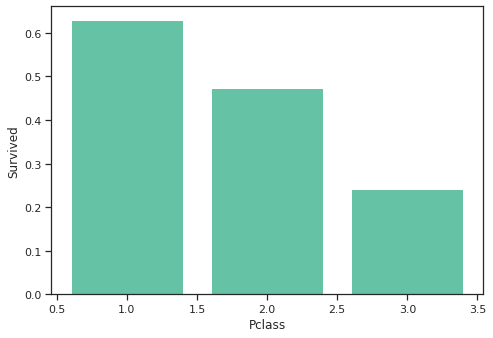

['S', 'C', 'Q']


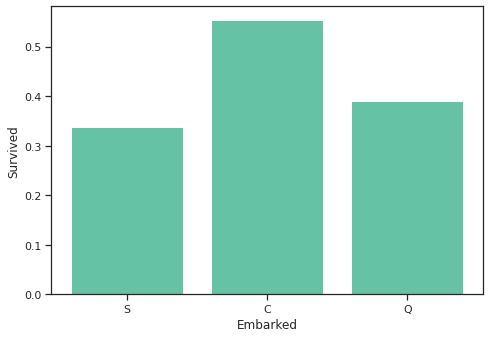

In [ ]:
train_data = pd.read_csv("train.csv")
def sort_age(age_keys, age_percents):
  result_keys = []
  result_percents = []
  true_labels = ["0-10","11-20","21-30","31-40","41-50","51-60","61-70","71-80"]
  curr_label_index = 0
  while curr_label_index < len(true_labels):
      for i in range(len(age_keys)):
        if age_keys[i] == true_labels[curr_label_index]:
          result_keys.append(age_keys[i])
          result_percents.append(age_percents[i])
          curr_label_index += 1
          break
  return result_keys, result_percents

def display_train_data(data, col1, col2):
  subset_data = data[[col1, col2]].dropna()
  counters_survived = {}
  counters_total = {}
  
  for i in range(len(subset_data)):
    key = subset_data.values[i,0]
    if col1 == "Age":
      if key != key:
        continue
      if key > 70 and key <= 80:
        key = "71-80"
      elif key > 60:
        key = "61-70"
      elif key > 50:
        key = "51-60"
      elif key > 40:
        key = "41-50"
      elif key > 30:
        key = "31-40"
      elif key > 20:
        key = "21-30"
      elif key > 10:
        key = "11-20"
      elif key >= 0:
        key = "0-10"
    val = counters_survived.get(key)
    if val == None:
      if subset_data.values[i,1] == 1:
        counters_survived.setdefault(key, 1)
      else:
        counters_survived.setdefault(key, 0)
      counters_total.setdefault(key, 1)
    else:
      if subset_data.values[i,1] == 1:
        counters_survived[key] = counters_survived.get(key)+1
      counters_total[key] = counters_total.get(key) + 1

  keys = counters_survived.keys()
  to_display_keys = []
  percents = []
  num_points = 0
  for key in keys:
    percents.append(counters_survived[key] / counters_total[key])
    to_display_keys.append(key)
    num_points += 1
  
  if col1 == "Age":
    to_display_keys, percents = sort_age(to_display_keys, percents)
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  print(to_display_keys)
  ax.bar(to_display_keys[0:num_points], percents[0:num_points])
  plt.xlabel(col1)
  plt.ylabel(col2)
  plt.show()

display_train_data(train_data, "Sex", "Survived")
display_train_data(train_data, "Age", "Survived")
display_train_data(train_data, "SibSp", "Survived")
display_train_data(train_data, "Parch", "Survived")
display_train_data(train_data, "Pclass", "Survived")
display_train_data(train_data, "Embarked", "Survived")

Building a model. The first one is a Decision tree

In [ ]:
path = "train.csv"

df = pd.read_csv(path)[["Survived", "Pclass", "Sex", "SibSp", "Age", "Fare", "Parch", "Embarked"]]
predictor_cols = ["Pclass", "Female", "SibSp", "Parch", "Fare", "Age"]

for i in range(len(df)):
  key = df["Age"].iloc[i]
  if key != key:
    key = np.nan
  else:
    key = round(key)
  df["Age"].iloc[i] = key
print(df)

df["Female"] = (df.Sex == "female").astype(float)
df = df.drop("Sex", axis="columns")

     Survived  Pclass     Sex  SibSp   Age     Fare  Parch Embarked
0           0       3    male      1  22.0   7.2500      0        S
1           1       1  female      1  38.0  71.2833      0        C
2           1       3  female      0  26.0   7.9250      0        S
3           1       1  female      1  35.0  53.1000      0        S
4           0       3    male      0  35.0   8.0500      0        S
..        ...     ...     ...    ...   ...      ...    ...      ...
886         0       2    male      0  27.0  13.0000      0        S
887         1       1  female      0  19.0  30.0000      0        S
888         0       3  female      1   NaN  23.4500      2        S
889         1       1    male      0  26.0  30.0000      0        C
890         0       3    male      0  32.0   7.7500      0        Q

[891 rows x 8 columns]


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Train the model

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.naive_bayes import *
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

path = "train.csv"

true_result = df["Survived"].to_numpy()

df = pd.read_csv(path)[["Survived", "Pclass", "Sex", "SibSp", "Parch", "Embarked"]]
def transform_df(my_df):
  for i in range(len(my_df)):
    key = my_df["Embarked"].iloc[i]
    if key == "S":
      key = "1"
    elif key == "Q":
      key = "2"
    elif key == "C":
      key = "3"
    else:
      key = "4"
    my_df["Embarked"].iloc[i] = key
  my_df["Embarked"] = my_df["Embarked"].astype(float)

  my_df["Female"] = (my_df.Sex == "female").astype(float)
  my_df = my_df.drop("Sex", axis="columns")
transform_df(df)
predictor_cols = ["Pclass", "Parch", "Female", "SibSp", "Embarked"]
tree_depth = 10000
model = DecisionTreeClassifier(max_depth=tree_depth, criterion="entropy")

model.fit(df[predictor_cols], df["Survived"])
result = model.predict(df[predictor_cols])
print ( "Accuracy on train survival = %.10f" % (metrics.accuracy_score(result, df["Survived"])) )
d_tree_n_pos = 0
d_tree_t_pos = 0
d_tree_f_pos = 0
d_tree_n_neg = 0
d_tree_t_neg = 0
d_tree_f_neg = 0
for i in range(len(result)):
  if result[i] == 1:
    d_tree_n_pos += 1.0
    if true_result[i] == 1:
      d_tree_t_pos += 1.0
    else:
      d_tree_f_pos += 1.0
  if result[i] == 0:
    d_tree_n_neg += 1.0
    if true_result[i] == 0:
      d_tree_t_neg += 1.0
    else:
      d_tree_f_neg += 1.0
d_tree_tpr = d_tree_t_pos / d_tree_n_pos
d_tree_fpr = d_tree_f_pos / d_tree_n_pos
d_tree_tnr = d_tree_t_neg / d_tree_n_neg
d_tree_fnr = d_tree_f_neg / d_tree_n_neg
print(d_tree_tpr)
print(d_tree_fpr)
print(d_tree_tnr)
print(d_tree_fnr)

#print(result, df["Survived"].to_numpy())
#fpr, tpr = roc_curve(result, df["Survived"].to_numpy())

from sklearn.neural_network import *
hidden_layer_size = 400
n_layers = 15
model = MLPClassifier(hidden_layer_sizes=(hidden_layer_size,n_layers),alpha=0.008,max_iter=5000,momentum=0.9,learning_rate_init=0.005)

model.fit(df[predictor_cols], df["Survived"])
result = model.predict(df[predictor_cols])
print ( "Accuracy on train data on an MLP classifier = %.10f" % (metrics.accuracy_score(result, df["Survived"])) )
mlp_n_pos = 0
mlp_t_pos = 0
mlp_f_pos = 0
mlp_n_neg = 0
mlp_t_neg = 0
mlp_f_neg = 0
for i in range(len(result)):
  if result[i] == 1:
    mlp_n_pos += 1.0
    if true_result[i] == 1:
      mlp_t_pos += 1.0
    else:
      mlp_f_pos += 1.0
  if result[i] == 0:
    mlp_n_neg += 1.0
    if true_result[i] == 0:
      mlp_t_neg += 1.0
    else:
      mlp_f_neg += 1.0
mlp_tpr = mlp_t_pos / mlp_n_pos
mlp_fpr = mlp_f_pos / mlp_n_pos
mlp_tnr = mlp_t_neg / mlp_n_neg
mlp_fnr = mlp_f_neg / mlp_n_neg
print(mlp_tpr)
print(mlp_fpr)
print(mlp_tnr)
print(mlp_fnr)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential(
    [
      layers.Dense(600, input_shape=(5,), activation = "relu"),
      layers.Dense(600, activation = "relu"),
      layers.Dense(600, activation = "relu"),
      layers.Dense(2, activation = "softmax")
    ]
)

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.018)
)
history = model.fit(df[predictor_cols].to_numpy(), df["Survived"].to_numpy(),batch_size=25,epochs=16,validation_split=0.15,verbose=0)

test_scores = model.evaluate(df[predictor_cols].to_numpy(), df["Survived"].to_numpy())
print(test_scores)
#print("Test loss:", test_scores[0])
#print("Test accuracy:", test_scores[1])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Accuracy on train survival = 0.8372615039
0.8832684824902723
0.11673151750972763
0.8186119873817035
0.18138801261829654
Accuracy on train data on an MLP classifier = 0.8181818182
0.8103448275862069
0.1896551724137931
0.8219633943427621
0.17803660565723795
28/28 [==============================] - 0s 3ms/step - loss: 0.4567
0.4567483067512512


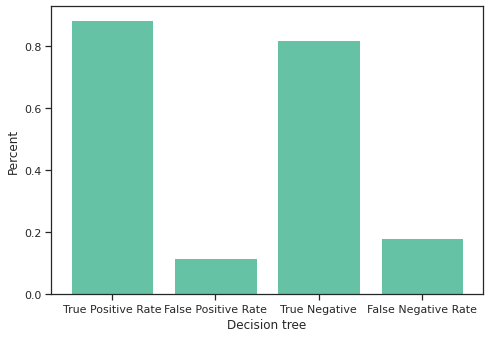

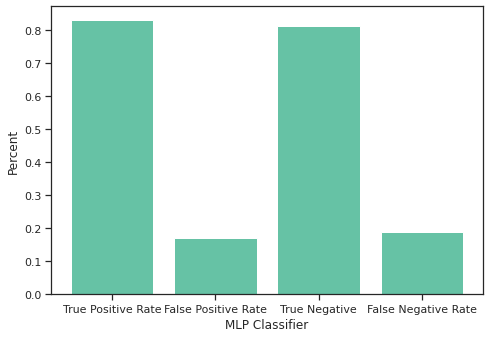

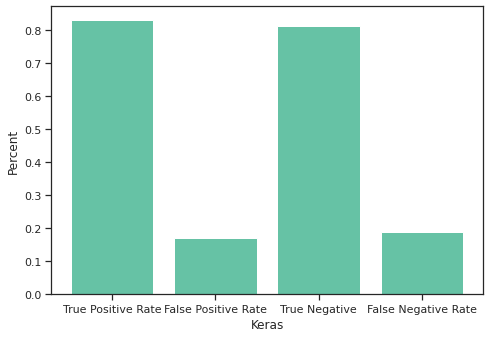

In [ ]:
def display_rates(keys, percents, model):
  
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.bar(keys, percents)
  plt.xlabel(model)
  plt.ylabel("Percent")
  plt.show()
keys = ["True Positive Rate", "False Positive Rate", "True Negative", "False Negative Rate"]
display_rates(keys, [d_tree_tpr, d_tree_fpr, d_tree_tnr, d_tree_fnr], "Decision tree")
display_rates(keys, [mlp_tpr, mlp_fpr, mlp_tnr, mlp_fnr], "MLP Classifier")
display_rates(keys, [keras_tpr, keras_fpr, keras_tnr, keras_fnr], "Keras")

Test the model

In [ ]:
path = "test.csv"

df = pd.read_csv(path)[["Pclass", "Parch", "Sex", "SibSp", "Embarked"]]
df["Female"] = (df.Sex == "female").astype(float)
df = df.drop("Sex", axis="columns")
for i in range(len(df)):
  key = df["Embarked"].iloc[i]
  if key == "S":
    key = "1"
  elif key == "Q":
    key = "2"
  elif key == "C":
    key = "3"
  else:
    key = "4"
  df["Embarked"].iloc[i] = key
df["Embarked"] = df["Embarked"].astype(float)

result = model.predict(df)
passenger_id = []
for i in range(1,len(result)+1):
  passenger_id.append(891 + i)
print(result)
print(passenger_id)
passenger_id = np.array(passenger_id)
survival_result = []
for i in range(len(result)):
  if result[i][0] > result[i][1]:
    survival_result.append(0)
  else:
    survival_result.append(1)
result_df = pd.DataFrame(survival_result,passenger_id)
result_df.to_csv("result.csv")

print(result_df)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


[[8.84523451e-01 1.15476593e-01]
 [5.91855288e-01 4.08144683e-01]
 [8.84853899e-01 1.15146101e-01]
 [8.84523451e-01 1.15476593e-01]
 [4.13982749e-01 5.86017251e-01]
 [8.84523451e-01 1.15476593e-01]
 [8.84523451e-01 1.15476593e-01]
 [6.10762835e-01 3.89237195e-01]
 [8.84523451e-01 1.15476593e-01]
 [2.93376297e-01 7.06623673e-01]
 [8.84523451e-01 1.15476593e-01]
 [6.66694820e-01 3.33305210e-01]
 [8.45854054e-04 9.99154091e-01]
 [6.02602541e-01 3.97397459e-01]
 [8.45854054e-04 9.99154091e-01]
 [8.18090339e-04 9.99181926e-01]
 [8.84853899e-01 1.15146101e-01]
 [8.90279591e-01 1.09720349e-01]
 [5.91855288e-01 4.08144683e-01]
 [8.84523451e-01 1.15476593e-01]
 [1.06913422e-14 1.00000000e+00]
 [8.84523451e-01 1.15476593e-01]
 [6.70679390e-01 3.29320669e-01]
 [8.84523451e-01 1.15476593e-01]
 [4.90613520e-01 5.09386480e-01]
 [8.84523451e-01 1.15476593e-01]
 [6.35272801e-01 3.64727229e-01]
 [8.90279591e-01 1.09720349e-01]
 [6.66694820e-01 3.33305210e-01]
 [1.20090204e-03 9.98799086e-01]
 [6.026025